In [3]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms

batch_size = 28
num_workers = 0
transforms = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers = 0)

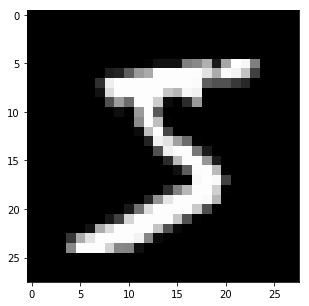

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter=iter(train_loader)
images,labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.en_fc1 = nn.Linear(784,512)
        self.en_fc2 = nn.Linear(512, 256)
        self.en_fc3 = nn.Linear(256,encoding_dim)
        # Decoder
        self.de_fc1 = nn.Linear(encoding_dim, 256)
        self.de_fc2 = nn.Linear(256, 512)
        self.de_fc3 = nn.Linear(512, 784)
        
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        #x = x.view(-1, 28*28)
        x = F.relu(self.en_fc1(x))
        x = self.dropout(x)
        x = F.relu(self.en_fc2(x))
        x = self.dropout(x)
        x = F.relu(self.en_fc3(x))
        x = self.dropout(x)
        x = F.relu(self.de_fc1(x))
        x = self.dropout(x)
        x = F.relu(self.de_fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.de_fc3(x))
        return x

encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (en_fc1): Linear(in_features=784, out_features=512, bias=True)
  (en_fc2): Linear(in_features=512, out_features=256, bias=True)
  (en_fc3): Linear(in_features=256, out_features=32, bias=True)
  (de_fc1): Linear(in_features=32, out_features=256, bias=True)
  (de_fc2): Linear(in_features=256, out_features=512, bias=True)
  (de_fc3): Linear(in_features=512, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

In [30]:
for epoch in range(n_epochs):
    train_loss = 0
    
    for data in train_loader:
        images, labels = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.64}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 1.2883565046251292951495770466863177716732025146484375
Epoch: 1 	Training Loss: 1.051518050247105318106832783087156713008880615234375
Epoch: 2 	Training Loss: 1.01015580370778845775703302933834493160247802734375
Epoch: 3 	Training Loss: 0.98837925448520014271025502239353954792022705078125
Epoch: 4 	Training Loss: 0.97409021732020584227740300775622017681598663330078125
Epoch: 5 	Training Loss: 0.96589831893849031896337464786483906209468841552734375
Epoch: 6 	Training Loss: 0.95956597721957737068265714697190560400485992431640625
Epoch: 7 	Training Loss: 0.9530691888584914561732830406981520354747772216796875
Epoch: 8 	Training Loss: 0.95080167004022431154197647629189305007457733154296875
Epoch: 9 	Training Loss: 0.94569637007903561976007722478243522346019744873046875
Epoch: 10 	Training Loss: 0.9424428933422197562919109259382821619510650634765625
Epoch: 11 	Training Loss: 0.9403310281598729059027164112194441258907318115234375
Epoch: 12 	Training Loss: 0.9397047589

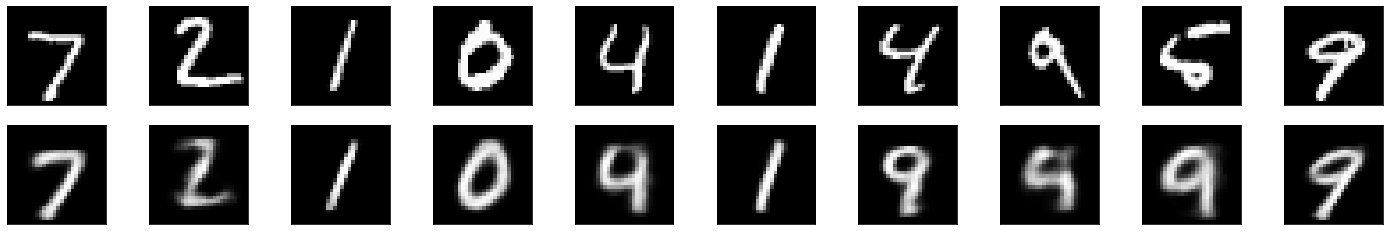

In [32]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images_flatten = images.view(images.size(0), -1)
output = model(images_flatten)
images = images.numpy()
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)